In [1]:
# import python packages, path and definitions
import os
import os.path as op
import mne
from mne.decoding import SlidingEstimator, GeneralizingEstimator
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import to_categorical, set_random_seed
import mne
from pathlib import Path
from base import *
from config import *
import pandas as pd
import numpy as np

In [2]:
subject = "sub-21"
sessions = SESS
data_dir = Path(f"/Users/coum/Desktop/{subject}")
verbose = True

all_epo, all_beh = list(), list()

for session in sessions:
    
    epoch_fname = data_dir / f"ses-{session}" / "meg" / "seq-epo.fif"
    epo = mne.read_epochs(epoch_fname, preload=True, verbose=verbose)
    all_epo.append(epo)

    beh_fname = data_dir / f"ses-{session}" / "beh" / "seq-beh.pkl"
    beh = pd.read_pickle(beh_fname)
    all_beh.append(beh)

epoch = mne.concatenate_epochs(all_epo, on_mismatch='ignore')
behav = pd.concat(all_beh)

times = all_epo[0].times

assert len(epoch) == len(behav)

Reading /Users/coum/Desktop/sub-21/ses-01/meg/seq-epo.fif ...
    Read 5 compensation matrices
    Found the data of interest:
        t =    -100.00 ...     600.00 ms
        5 CTF compensation matrices available
Not setting metadata
950 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/coum/Desktop/sub-21/ses-02/meg/seq-epo.fif ...
    Read 5 compensation matrices
    Found the data of interest:
        t =    -100.00 ...     600.00 ms
        5 CTF compensation matrices available
Not setting metadata
949 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1899 matching events found
Applying baseline correction (mode: mean)


/var/folders/y_/m3qn82z15yb4fhdtdwn9vp_h0000gq/T/ipykernel_60642/41647551.py:18: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epoch = mne.concatenate_epochs(all_epo, on_mismatch='ignore')


In [3]:
t_min = min(times)
t_max = max(times)
cropped_epo = epoch.copy().crop(t_min, t_max, verbose=verbose)
X_win = cropped_epo.pick_types(meg=True, ref_meg=False, stim=False).get_data(copy=True)
X_rnn = np.swapaxes(X_win, 1, 2)
print(X_rnn.shape)

y = behav.response.values
print(y.shape)

X_rnn = np.delete(X_rnn, -1, axis=0)
y = np.delete(y, 0)

print(X_rnn.shape)
print(y.shape)

assert X_rnn.shape[0] == y.shape[0]

print("X_rnn shape:", X_rnn.shape)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing 5 compensators from info because not all compensation channels were picked.
(1899, 85, 274)
(1899,)
(1898, 85, 274)
(1898,)
X_rnn shape: (1898, 85, 274)


In [5]:
X_rnn.shape

(1898, 85, 274)

In [6]:
# To Simplify everything here, we don't use CV anymore. Data are of shape (nb time points, nb channels).
# We standardize each sample independently (see below)
X_rnn_stand = np.zeros_like(X_rnn)
for i in range(0, X_rnn.shape[0]):
    X_rnn_stand[i,] = (X_rnn[i,] - X_rnn[i,].mean()) / X_rnn[i,].std()
print(X_rnn_stand.shape)

test_perc = .1
train_samples = int(X_rnn.shape[0] - X_rnn.shape[0] * test_perc)
test_samples = int(X_rnn.shape[0] * test_perc)

xtrain = X_rnn_stand[:train_samples]
xtest = X_rnn_stand[-test_samples:]

# xtrain = X_rnn[:train_samples]
# xtest = X_rnn[-test_samples:]

ytrain = y[:train_samples] - 1
ytest = y[-test_samples:] - 1

assert len(xtest) + len(xtrain) == len(ytrain) + len(xtest)

(1898, 85, 274)


In [7]:
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(1708, 85, 274)
(1708,)
(189, 85, 274)
(189,)


In [8]:
# To save best model

ckpt_fname = data_dir / "ckpt"
ensure_dir(ckpt_fname)

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=ckpt_fname,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [15]:
# normalizer = keras.layers.Normalization(axis=1)
# normalizer.adapt(xtrain)

epochs = 200

model = keras.Sequential(
    [
        keras.Input(shape=(xtrain.shape[1:])),
        # normalizer,
        layers.LSTM(5, activation="softmax"),
        # layers.Dropout(0.2),
        # layers.Dense(24, activation='relu'),
    ]
)

model.summary()
model.compile(optimizer=keras.optimizers.Adam(0.0001),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])

history = model.fit(xtrain, ytrain, 
                    epochs=epochs, 
                    validation_split=0.1, 
                    batch_size=xtrain.shape[0], 
                    callbacks=[model_checkpoint_callback])

ypred = model.predict(xtest)
print(model.summary)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 5)                 5600      
                                                                 
Total params: 5,600
Trainable params: 5,600
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 2.1959 - accuracy: 0.2069 - val_loss: 2.1589 - val_accuracy: 0.1930
Epoch 2/200
1/1 [==============================] - 0s 264ms/step - loss: 2.1779 - accuracy: 0.2075 - val_loss: 2.1484 - val_accuracy: 0.1930
Epoch 3/200
1/1 [==============================] - 0s 251ms/step - loss: 2.1604 - accuracy: 0.2075 - val_loss: 2.1383 - val_accuracy: 0.1871
Epoch 4/200
1/1 [==============================] - 0s 225ms/step - loss: 2.1434 - accuracy: 0.2075 - val_loss: 2.1286 - val_accuracy: 0.1813
Epoch 5/200
1/1 [==

accuracy score:  0.2751322751322751


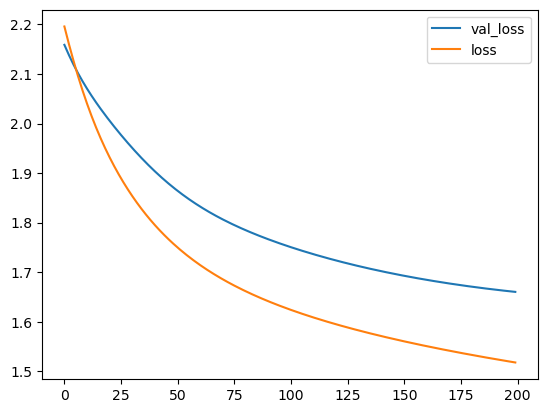

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

predicted_class_labels = np.argmax(ypred, axis=1)
print("accuracy score: ", accuracy_score(ytest, predicted_class_labels))

plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.show()

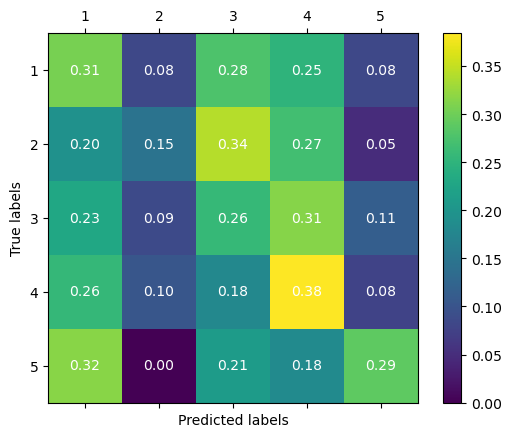

In [18]:
conf_mat = confusion_matrix(ytest.astype('int64'),predicted_class_labels.astype('int64'), normalize='true')
# Print confusion matrix
fig2 = plt.figure()
ax = fig2.add_subplot(111)
cax = ax.matshow(conf_mat)
for (i, j), value in np.ndenumerate(np.swapaxes(conf_mat,0,1)):
    plt.text(i, j, f"{value:.2f}", va="center", ha="center",c="white")
ax.set_xticks(range(5))
ax.set_xticklabels(range(6)[1:])
ax.set_yticks(range(5))
ax.set_yticklabels(range(6)[1:])
fig2.colorbar(cax)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()